# Clase 12

## 1. Apredenzaje en conjunto

## 2. Combinar modelos mediante votación

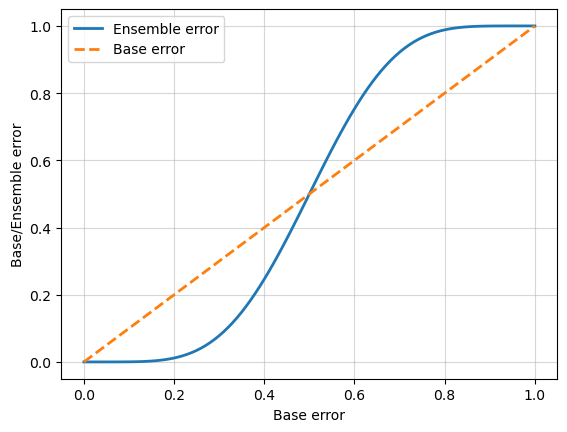

In [1]:
from scipy.special import comb
import math
import numpy as np
import matplotlib.pyplot as plt
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range,
ens_errors,
label='Ensemble error',
linewidth=2)
plt.plot(error_range,
error_range,
linestyle='--',
label='Base error',
linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
#plt.savefig('images/07_03.png', dpi=300)
plt.show()

### 2.1 Implementacion de un Clasificador por Mayoria Simple
* Voto Mayotitario Ponderado 

In [8]:
#                       Clases              pesos sum=1
np.argmax(np.bincount([1, 1, 0, 0], weights=[0.2, 0.2, 0.2, 0.2]))

0

In [3]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier
    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
    Different classifiers for the ensemble
    vote : str, {'classlabel', 'probability'} (default='label')
    If 'classlabel' the prediction is based on the argmax of
    class labels. Else if 'probability', the argmax of
    the sum of probabilities is used to predict the class label
    (recommended for calibrated classifiers).
    weights : array-like, shape = [n_classifiers], optional (default=None)
    If a list of `int` or `float` values are provided, the classifiers
    are weighted by importance; Uses uniform weights if `weights=None`.
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """ Fit classifiers.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Matrix of training samples.
        y : array-like, shape = [n_samples]
        Vector of target class labels.
        Returns
        -------
        self : object
        """
        #Probability: moda
        #classlabel: pesos
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                            % self.vote)
        
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
            '; got %d weights, %d classifiers'
            % (len(self.weights), len(self.classifiers)))
        
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Matrix of training samples.
        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
        Predicted class labels.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x,weights=self.weights)),axis=1,arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples and
        n_features is the number of features.
        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
        Weighted average probability for each class per sample.
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
        return out

In [9]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=1, stratify=y)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2',C=0.001,random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],['clf', clf1]])
#No es necesario estandarizar el arbol de decisiones
pipe3 = Pipeline([['sc', StandardScaler()],['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
        % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [11]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
        % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


### 2.1.1 Curvas ROC

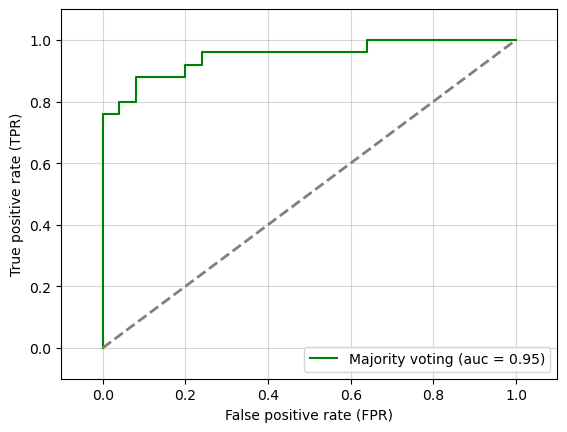

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf,clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr,color=clr,linestyle=ls,label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],linestyle='--',color='gray',linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
#plt.savefig('images/07_04', dpi=300)
plt.show()

c:\Users\Javiera Carrasco\anaconda3\envs\ima539\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Javiera Carrasco\anaconda3\envs\ima539\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value

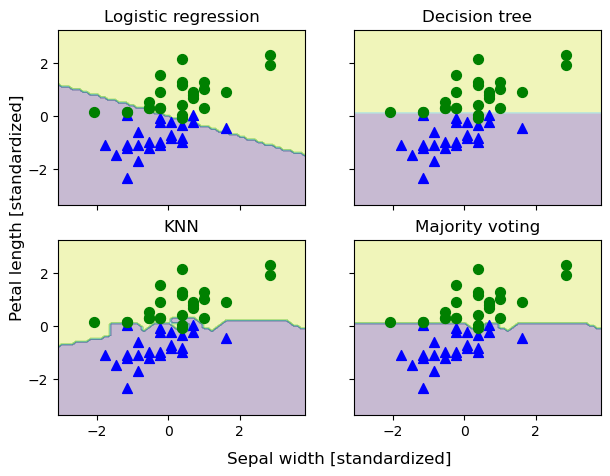

In [13]:
from itertools import product
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
all_clf = [pipe1, clf2, pipe3, mv_clf]
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row',figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
    X_train_std[y_train==0, 1],
    c='blue',
    marker='^',
    s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
    X_train_std[y_train==1, 1],
    c='green',
    marker='o',
    s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5.,s='Sepal width [standardized]',ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,s='Petal length [standardized]',ha='center', va='center',fontsize=12, rotation=90)
#plt.savefig('images/07_05', dpi=300)
plt.show()

In [14]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [15]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth':[1, 2],'pipeline-1__clf__C':[0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf,param_grid=params,cv=10,scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.5f +/- %0.3f %r"
        % (grid.cv_results_['mean_test_score'][r],
        grid.cv_results_['std_test_score'][r] / 2.0,
        grid.cv_results_['params'][r]))

0.98333 +/- 0.025 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.98333 +/- 0.025 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.96667 +/- 0.050 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.98333 +/- 0.025 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.98333 +/- 0.025 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.96667 +/- 0.050 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [11]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
Accuracy: 0.98


In [12]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [13]:
mv_clf = grid.best_estimator_

In [14]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

## Adaptative Boosting  (AdaBoost)

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2',C=0.001,random_state=1)
ada = AdaBoostClassifier(base_estimator=lr,n_estimators=200,learning_rate=0.1,random_state=1)

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print('AdaBoost train/test accuracies %.3f/%.3f'
    % (ada_train, ada_test))
lr = lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
lr_train = accuracy_score(y_train, y_train_pred)
lr_test = accuracy_score(y_test, y_test_pred)
print('LR train/test accuracies %.3f/%.3f'
    % (lr_train, lr_test))

AdaBoost train/test accuracies 0.780/0.680
LR train/test accuracies 0.940/0.920


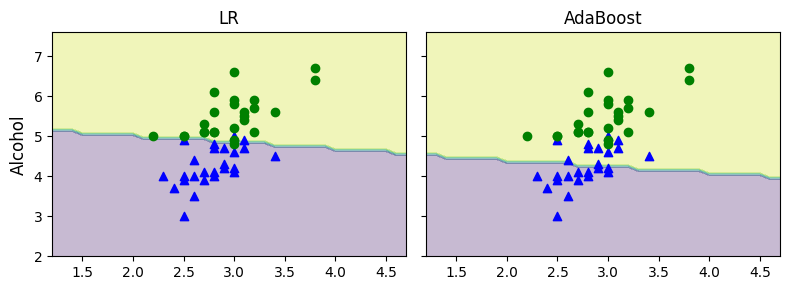

In [17]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))
for idx, clf, tt in zip([0, 1],[lr, ada],['LR', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],X_train[y_train == 0,1],c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],X_train[y_train == 1,1],c='green', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
#plt.savefig('images/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

## TAREA FINAL
1) Aplicar AdaBoost con SVM.
2) Aplicar Adaboost con Árbol de Decisión.

In [20]:
#1)
from sklearn.svm import SVC

svm = SVC(kernel='rbf',C=0.01,random_state=1)
ada = AdaBoostClassifier(base_estimator=svm,n_estimators=20,learning_rate=0.1,random_state=1)

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print('AdaBoost train/test accuracies %.3f/%.3f'
    % (ada_train, ada_test))


TypeError: AdaBoostClassifier with algorithm='SAMME.R' requires that the weak learner supports the calculation of class probabilities with a predict_proba method.
Please change the base estimator or set algorithm='SAMME' instead.

In [22]:
#2)
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini',max_depth=5,random_state=1)
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=20,learning_rate=0.1,random_state=1)

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print('AdaBoost train/test accuracies %.3f/%.3f'
    % (ada_train, ada_test))

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
lr_train = accuracy_score(y_train, y_train_pred)
lr_test = accuracy_score(y_test, y_test_pred)
print('Tree train/test accuracies %.3f/%.3f'
    % (lr_train, lr_test))

AdaBoost train/test accuracies 1.000/0.900
Tree train/test accuracies 1.000/0.900


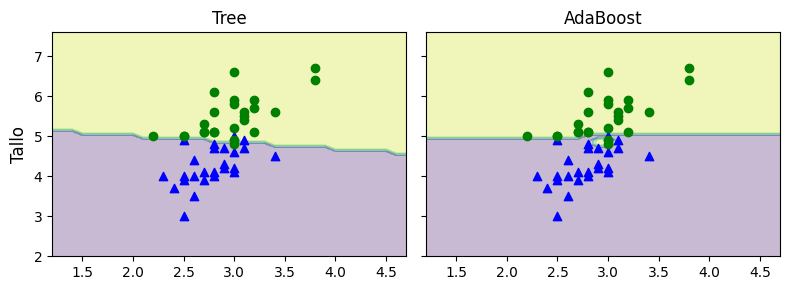

In [23]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))
for idx, clf, tt in zip([0, 1],[lr, ada],['Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],X_train[y_train == 0,1],c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],X_train[y_train == 1,1],c='green', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Tallo', fontsize=12)
plt.tight_layout()
#plt.savefig('images/07_11.png', dpi=300, bbox_inches='tight')
plt.show()